Protected Lands
===

This notebook merges FieldDoc protected lands with PASDA protected lands and plots the distribution of protection type in each cluster and subbasin.

# Setup

In [1]:
# Import packages
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
os.getcwd()

'C:\\Users\\clulay\\OneDrive - LimnoTech\\Documents\\GitHub\\pollution-assessment\\stage2'

# Load data

In [3]:
# Import weconservePA protected lands
wcpa_gdf = gpd.read_file('./Protected_Lands/WeConservePA_pl_20220810.shp')

wcpa_gdf['data_source'] = 'weconservePA'
wcpa_gdf.head(n=1)

,OBJECTID,Category,sitename,esmthldr,eholdtype,own_name,own_type,URL,purpose,year_est,...,County,Municipali,Muni_Type,Muni,MMW,Shape_Leng,Shape_Area,RECLASS2,geometry,data_source
0,1,Government Agricultural Easement,A & A Likanchuk Enterprises,Cumberland County,Local,None,Private,http://www.co.cumberland.nj.us/content/22602/2...,Open Space - Farm,2019,...,Cumberland,Hopewell Township,Township,None,Agricultural Easement,3423.049486,187004.776462,Agricultural Easement,"POLYGON ((1751532.341 407777.856, 1751099.644 ...",weconservePA


In [4]:
# Convert shape area from m^2 to acres
wcpa_gdf['Area_Ac'] = wcpa_gdf['Shape_Area']/4046.86
wcpa_gdf.head(n=1)

,OBJECTID,Category,sitename,esmthldr,eholdtype,own_name,own_type,URL,purpose,year_est,...,Municipali,Muni_Type,Muni,MMW,Shape_Leng,Shape_Area,RECLASS2,geometry,data_source,Area_Ac
0,1,Government Agricultural Easement,A & A Likanchuk Enterprises,Cumberland County,Local,None,Private,http://www.co.cumberland.nj.us/content/22602/2...,Open Space - Farm,2019,...,Hopewell Township,Township,None,Agricultural Easement,3423.049486,187004.776462,Agricultural Easement,"POLYGON ((1751532.341 407777.856, 1751099.644 ...",weconservePA,46.209846


In [5]:
# Import FieldDoc protected lands 
fielddoc_gdf = gpd.read_parquet("./private/protection_df.parquet")

# Add a column to fielddoc_gdf with data source
fielddoc_gdf['data_source'] = 'fielddoc_2022-08-11'
fielddoc_gdf.head(n=1)

,,huc12,practice_name,program_name,program_id,organization,description,practice_type,created_at,modified_at,bmp_size,bmp_size_unit,geom,data_source
comid,practice_id,,,,,,,,,,,,,
2583191,54313,020401050101,Culvers Brook Preserve II - Subject - Fee Acqu...,Delaware River Watershed Protection Fund - For...,5,New Jersey Conservation Foundation,None,Fee acquisition,2021-11-23 21:16:32.491086+00:00,2021-12-07 14:29:21.209918+00:00,8.52,ACRES,"MULTIPOLYGON (((-74.75218 41.16936, -74.75349 ...",fielddoc_2022-08-11


In [6]:
# Import cluster and focus area geometries
cluster_gdf = gpd.read_parquet('../stage1/data/cluster_df.parquet')  
focusarea_gdf = gpd.read_parquet('../stage1/data/fa_phase2_df.parquet')
focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') # update name for consistency with other files 
focusarea_gdf.set_index('name', inplace=True)

# Reproject coordinate systems

In [7]:
# Check coordinate systems
wcpa_gdf.crs

<Derived Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
fielddoc_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# Reproject CRS to 3857
wcpa_gdf.to_crs(epsg=3857, inplace=True)
fielddoc_gdf.to_crs(epsg=3857, inplace=True)
focusarea_gdf.to_crs(epsg=3857, inplace=True)
cluster_gdf.to_crs(epsg=3857, inplace=True)

<AxesSubplot:>

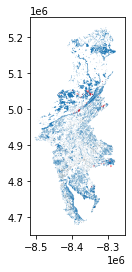

In [10]:
# Plot weconservePA and fielddoc protected lands 
plt.rcParams["figure.figsize"] = (20,20)
fig, ax1 = plt.subplots()
wcpa_gdf.plot(ax=ax1)
cmap = ListedColormap(['red'],name='allred')
fielddoc_gdf.plot(ax=ax1,cmap=cmap)

# Merge geodataframes

## Subtract field doc lands from weconservePA to remove any overlap

In [11]:
wcpa_gdf['Area_Ac'].sum()

2160468.9511223272

In [12]:
# Subtract field doc lands from weconservePA lands
dif_gdf = wcpa_gdf.overlay(fielddoc_gdf, how='difference', keep_geom_type=False)

In [13]:
dif_gdf['Area_Ac'].sum()

2160468.9511223272

<AxesSubplot:>

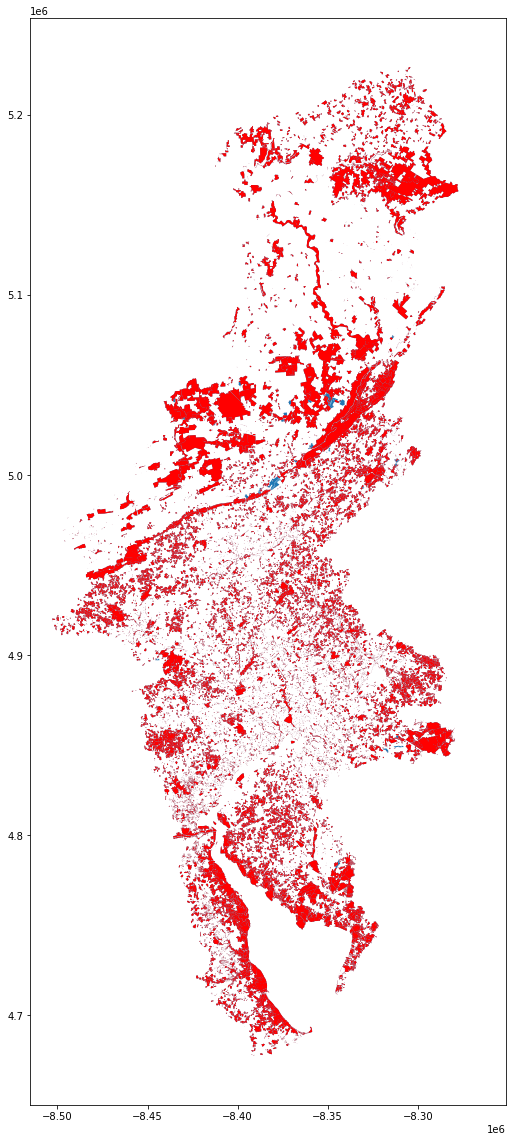

In [14]:
# Plot original weconservePA data against difference gdf
plt.rcParams["figure.figsize"] = (20,20)
fig, ax1 = plt.subplots()
wcpa_gdf.plot(ax=ax1)
cmap = ListedColormap(['red'],name='allred')
dif_gdf.plot(ax=ax1,cmap=cmap)

## Append field doc with weconservePA protected lands

In [15]:
# Clean up column headers to match in merge
wcpa_simp_gdf = dif_gdf[['sitename','esmthldr','purpose','RECLASS2','data_source','Area_Ac','geometry']]
wcpa_simp_gdf.rename(columns={'sitename': 'practice_name', 'purpose': 'description',
                              'esmthldr': 'organization', 'RECLASS2': 'practice_type',
                              'geometry': 'geom'}, inplace=True)

fielddoc_gdf.rename(columns={'bmp_size': 'Area_Ac'}, inplace=True)

C:\Users\clulay\AppData\Local\Temp\ipykernel_34916\1742967935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wcpa_simp_gdf.rename(columns={'sitename': 'practice_name', 'purpose': 'description',


In [16]:
# Append field doc protected lands with pasda protected lands
all_pl_gdf = fielddoc_gdf.append(wcpa_simp_gdf)
all_pl_gdf.head(n=1)

# Clean up all protected land gdf
#all_pl_gdf = all_pl_gdf[['practice_name', 'program_name', 'organization','practice_type', 'data_source', 'geom']]

C:\Users\clulay\AppData\Local\Temp\ipykernel_34916\2924458830.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_pl_gdf = fielddoc_gdf.append(wcpa_simp_gdf)


,huc12,practice_name,program_name,program_id,organization,description,practice_type,created_at,modified_at,Area_Ac,bmp_size_unit,geom,data_source
"(2583191, 54313)",020401050101,Culvers Brook Preserve II - Subject - Fee Acqu...,Delaware River Watershed Protection Fund - For...,5.0,New Jersey Conservation Foundation,None,Fee acquisition,2021-11-23 21:16:32.491086+00:00,2021-12-07 14:29:21.209918+00:00,8.52,ACRES,"MULTIPOLYGON (((-8321374.316 5037354.416, -832...",fielddoc_2022-08-11


# Plot distribution of protected lands

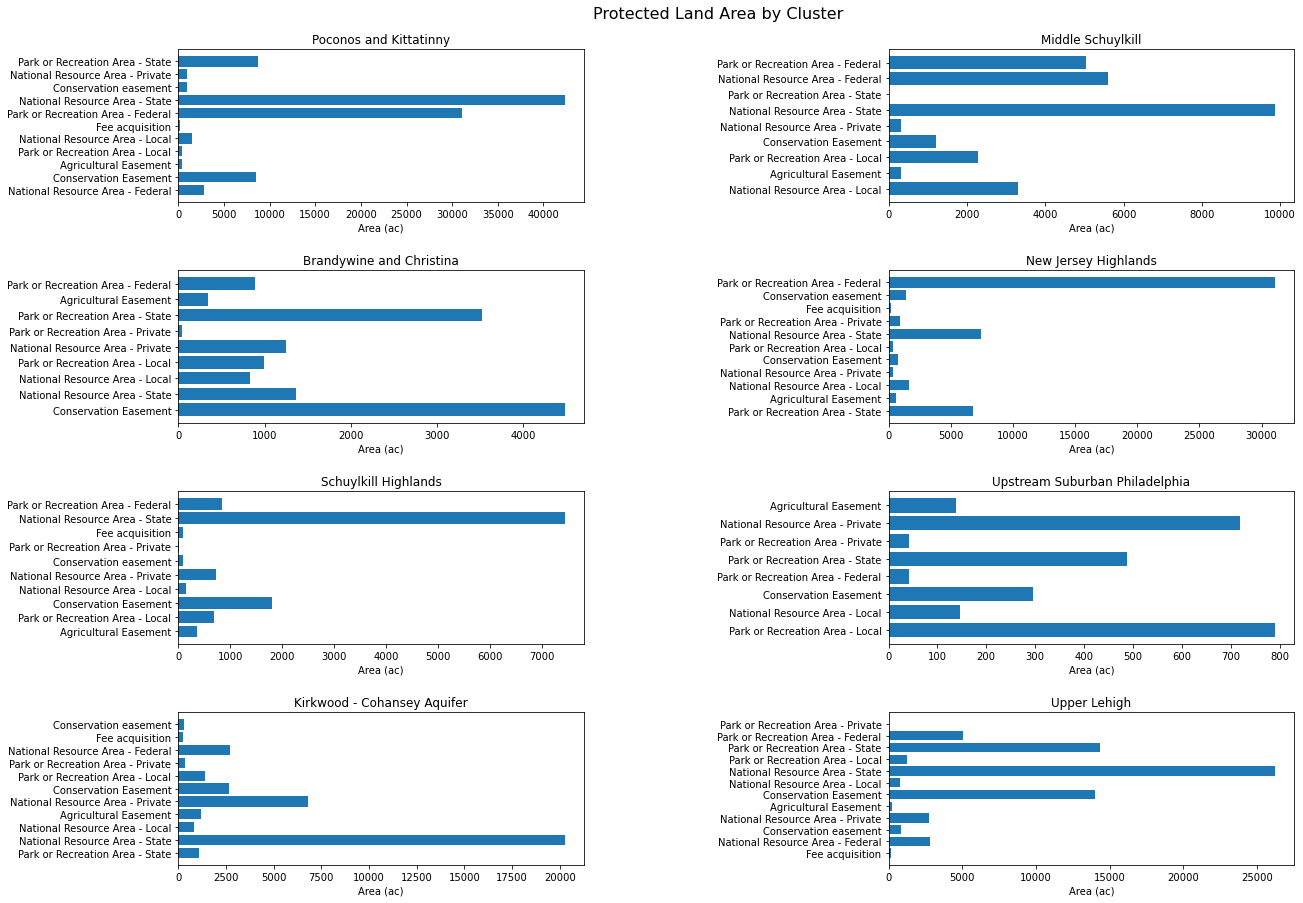

In [17]:
# Plot distribution of protected land area for each cluster
fig, ax = plt.subplots(4,2, figsize=(20,15))
plt.subplots_adjust(hspace=0.45,wspace=0.75)
fig.suptitle('Protected Land Area by Cluster',fontsize=16,y=0.92)
n=0

for ind in cluster_gdf.index:
    geom = cluster_gdf.loc[[ind]]
    in_cluster = all_pl_gdf.clip(geom)
    n = n+1
    ax = plt.subplot(4,2,n)
    plt.xlabel('Area (ac)')
    plt.title(ind)
    
    plt.barh(in_cluster['practice_type'], width=in_cluster['Area_Ac'])

In [18]:
focusarea_gdf.index

Index(['Brandywine Creek Headwaters', 'Plum Run', 'Red Clay Creek',
       'White Clay Creek', 'Cohansey River', 'Lower Salem River', 'Menantico',
       'Muddy Run', 'Rancocas', 'Upper Salem River', 'Furnace Cr',
       'Hosensack Cr', 'Licking Cr', 'Lower Maiden Cr Trib 1',
       'Lower Maiden Cr Trib 3', 'Manatawny Trib 2', 'Manatawny Trib 3',
       'Manor Cr', 'Mill Cr Berger', 'Mill Cr Trib 2', 'Mill Cr Younker',
       'Moselem Cr', 'Tulpehocken Trib 2', 'Tulpehocken Trib 3',
       'Little Manatawny Trib 4', 'Lower Maiden Cr Trib 2',
       'Middle Maiden Trib', 'Northkill', 'Saucony Cr Trib 1',
       'Saucony Cr Trib 2', 'Beaver Brook', 'Lopatcong Creek',
       'Lower Middle Musconetcong', 'Paulinskill', 'Upper Musconetcong',
       'Brodhead', 'Cherry Valley', 'Eastern Mongaup', 'Little Bushkill',
       'Lower Bashakill', 'Lower Neversink', 'Rattlesnake Creek',
       'Upper Neversink', 'Hay Creek', 'Bryn Coed', 'Pigeon Run',
       'Pine Creek - French', 'Pine Creek - Pi

CPU times: total: 4.19 s
Wall time: 4.18 s


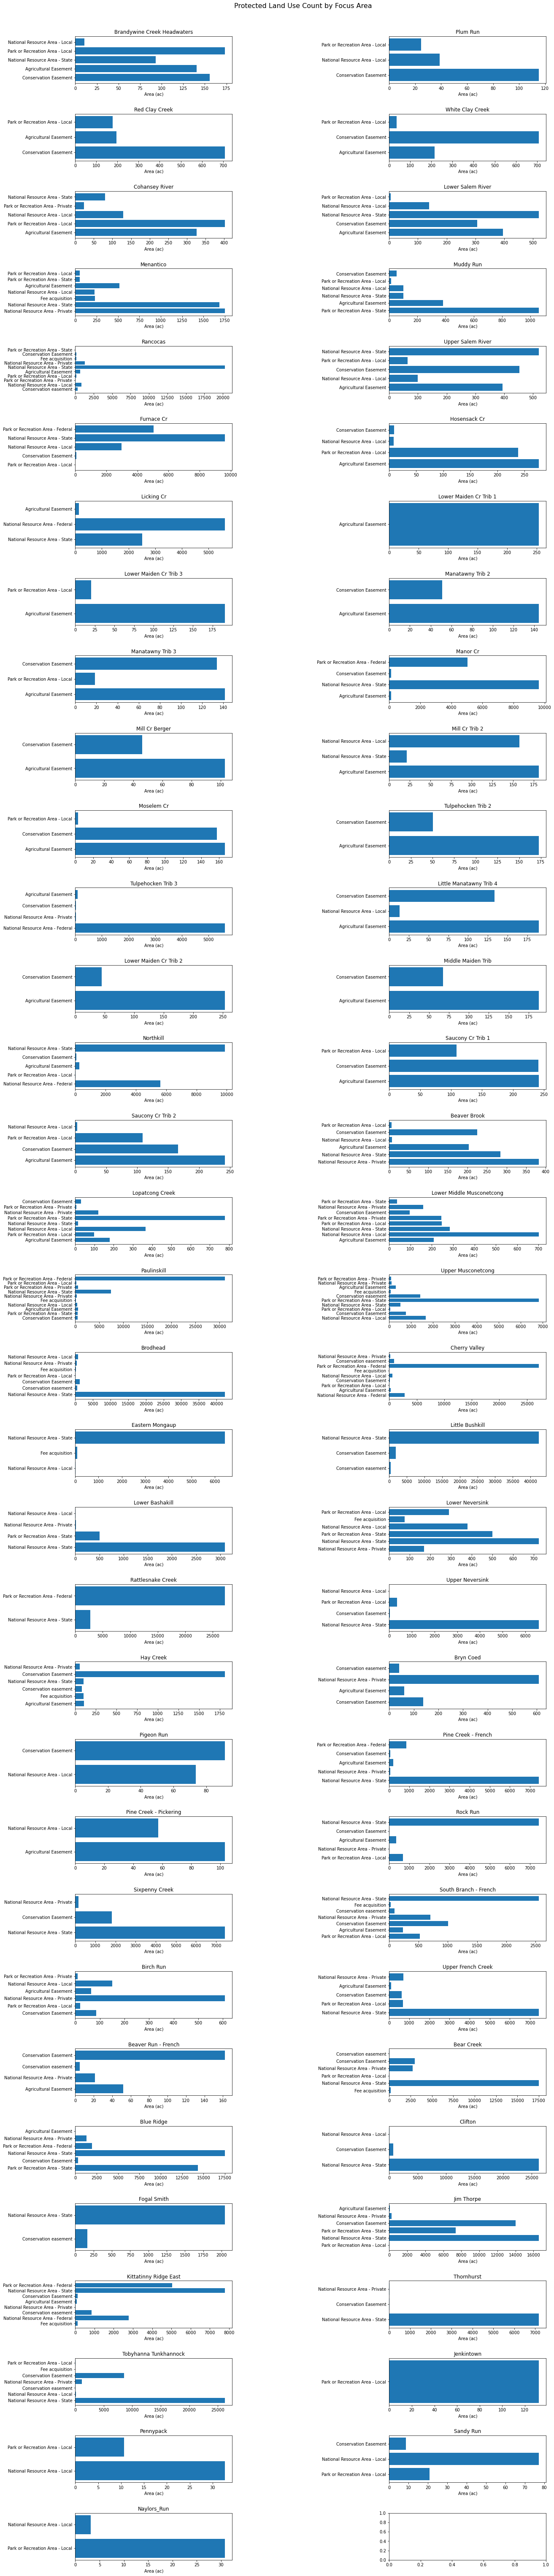

In [19]:
%%time
# Plot distribution of protected land area for each focus area
fig, ax = plt.subplots(33,2, figsize=(20,110))
plt.subplots_adjust(hspace=0.65,wspace=1)
fig.suptitle('Protected Land Area by Focus Area',fontsize=16,y=0.89)
n=0

for ind in focusarea_gdf.index:
    geom = focusarea_gdf.loc[[ind]]
    in_fa = all_pl_gdf.clip(geom)
    
    if in_fa.size != 0:
        n = n+1
        ax = plt.subplot(33,2,n) 
        plt.xlabel('Area (ac)')
        plt.title(ind)
        
        plt.barh(in_fa['practice_type'], width=in_fa['Area_Ac'])